In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
tf.keras.utils.set_random_seed(42)
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Change to statsmodels.tsa.arima.model on jupyter notebook
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from fbprophet import Prophet

import warnings
warnings.simplefilter('ignore')

plt.style.use("fivethirtyeight")

In [56]:
# For working on google colab. Comment out if working on Jupyter Notebook.
# from google.colab import files
# uploaded = files.upload()

Saving index_funds_data.csv to index_funds_data (2).csv


In [57]:
# remove '..data/' if working on google colab
funds = pd.read_csv('../data/index_funds_data.csv')
funds['date'] = pd.to_datetime(funds['date'],infer_datetime_format=True)
funds = funds[['symbol','date','close']]
funds = funds.set_index(['symbol','date'])
IVV = funds.loc['IVV',['close']]

In [58]:
IVV

,close
date,
2017-01-12 00:00:00+00:00,227.97
2017-01-13 00:00:00+00:00,228.39
2017-01-14 00:00:00+00:00,227.64
2017-01-15 00:00:00+00:00,227.64
2017-01-16 00:00:00+00:00,227.64
...,...
2022-01-06 00:00:00+00:00,469.98
2022-01-07 00:00:00+00:00,468.10
2022-01-08 00:00:00+00:00,467.22


In [59]:
IVV.shape

(1825, 1)

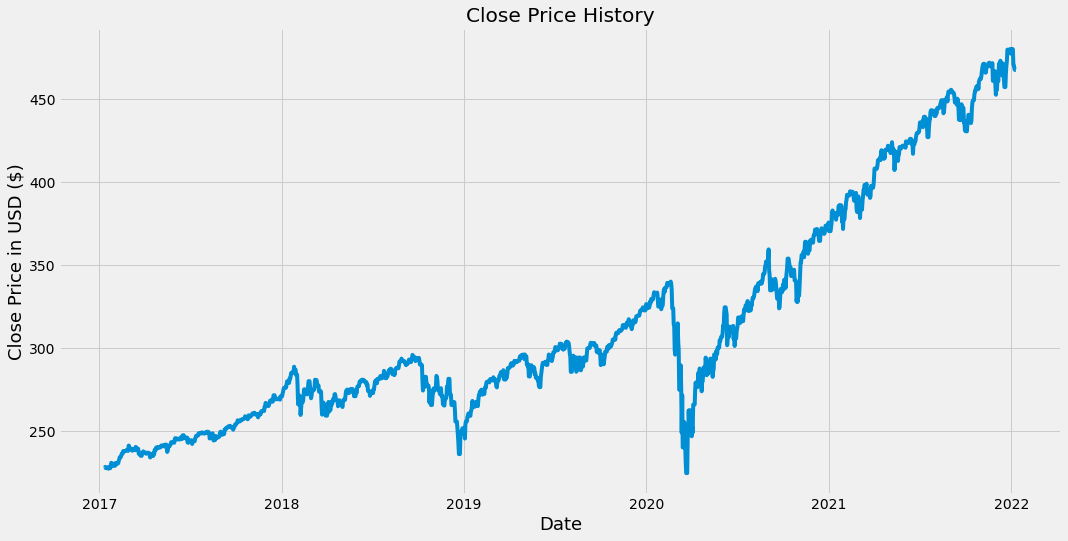

In [60]:
plt.figure(figsize=(16,8))
plt.plot(IVV['close'])
plt.title("Close Price History")
plt.xlabel("Date",fontsize=18)
plt.ylabel("Close Price in USD ($)",fontsize=18)
plt.show()

### Baseline

In [61]:
IVV_baseline = IVV.shift(30)
IVV_base_rmse = mean_squared_error(IVV[30:],IVV_baseline[30:],squared=False)
IVV_base_rmse

15.624003253930473

In [62]:
IVV_baseline

,close
date,
2017-01-12 00:00:00+00:00,NaN
2017-01-13 00:00:00+00:00,NaN
2017-01-14 00:00:00+00:00,NaN
2017-01-15 00:00:00+00:00,NaN
2017-01-16 00:00:00+00:00,NaN
...,...
2022-01-06 00:00:00+00:00,470.19
2022-01-07 00:00:00+00:00,471.43
2022-01-08 00:00:00+00:00,468.25


In [63]:
IVV

,close
date,
2017-01-12 00:00:00+00:00,227.97
2017-01-13 00:00:00+00:00,228.39
2017-01-14 00:00:00+00:00,227.64
2017-01-15 00:00:00+00:00,227.64
2017-01-16 00:00:00+00:00,227.64
...,...
2022-01-06 00:00:00+00:00,469.98
2022-01-07 00:00:00+00:00,468.10
2022-01-08 00:00:00+00:00,467.22


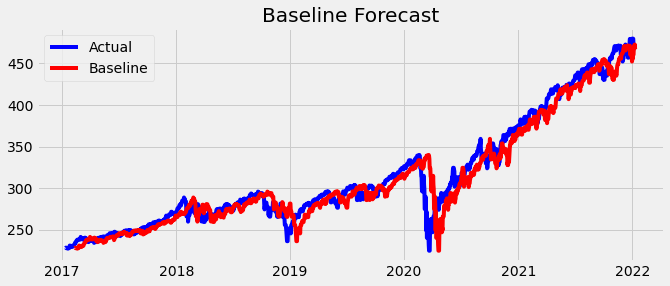

In [64]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_title("Baseline Forecast")
ax.plot(IVV,c='b',label='Actual')
ax.plot(IVV_baseline,c='r',label='Baseline')
plt.legend()
plt.show()

In [65]:
new_df = pd.DataFrame()
new_df['original'] = IVV['close']
new_df['shifted'] = IVV['close'].shift(30)
cutoff = int(len(new_df['original']) * 0.80)
original = new_df['original']
shifted = new_df['shifted']
original_train, original_test = original[30:cutoff], original[cutoff:]
shifted_train, shifted_test = shifted[30:cutoff], shifted[cutoff:]

In [66]:
baseline_rmse = mean_squared_error(original_train,shifted_train,squared=False)
baseline_rmse

16.09170879619279

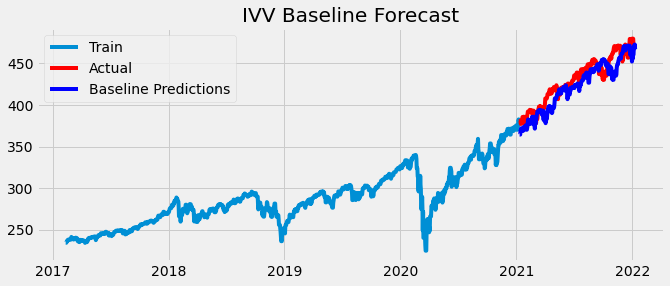

In [67]:
plt.figure(figsize=(10,4))
plt.title('IVV Baseline Forecast')
plt.plot(original_train,label='Train')
plt.plot(original_test,c='r',label='Actual')
plt.plot(shifted_test,c='blue',label='Baseline Predictions')
plt.legend()
plt.show()

### ARIMA Model

In [68]:
def get_combos(n,k):
    p = d = q = range(n, k)
    pdq = list(itertools.product(p, d, q))
    pdqs = [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]
    return pdqs

def get_optimal_params(ts,n,k):
    pdq = get_combos(n,k)
    ans = []
    for comb in pdq:
        try:
            model = ARIMA(ts,
                         order=comb)
            output = model.fit()
            ans.append([comb,output.aic])
        except:
            continue
    ans_df = pd.DataFrame(ans, columns=['pdq','aic'])
    optimals = ans_df.loc[ans_df['aic'].idxmin()]
    return optimals

def arima_models(ts,n,k):
    order = get_optimal_params(ts,n,k)['pdq']
    model = ARIMA(ts,
                 order=order)
    output = model.fit()
    return output



In [69]:
def train_test_splt(ts,test_size):
    cutoff = int(ts.shape[0]*(1-test_size))
    train = ts[:cutoff]
    test = ts[cutoff:]
    return train, test

IVV_train, IVV_test = train_test_splt(IVV,.2)

In [70]:
# Find optimal pdq
print(get_optimal_params(IVV_train,0,3))

# Fit ARIMA with optimal pdq
arima_model = arima_models(IVV_train,0,3)

# Summary of model
arima_model.summary()

pdq    (2, 1, 2)
aic      7261.01
Name: 22, dtype: object


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.close   No. Observations:                 1459
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3624.505
Method:                       css-mle   S.D. of innovations              2.901
Date:                Thu, 20 Jan 2022   AIC                           7261.010
Time:                        03:05:28   BIC                           7292.723
Sample:                    01-13-2017   HQIC                          7272.841
                         - 01-10-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1043      0.072      1.447      0.148      -0.037       0.245
ar.L1.D.close    -1.8286      0.023    -80.986      0.000      -1.873      -1.784
ar.L2.D.close    -0.8940      0.022    -40.224      0.000      -0.938      -0.850
ma.L1.D.close     1.7435      0.030     57.257      0.000       1.684       1.803
ma.L2.D.close     0.7875      0.029     26.925      0.000       0.730       0.845
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0227           -0.2696j            1.0576           -0.4590
AR.2           -1.0227           +0.2696j            1.0576            0.4590
MA.1           -1.1070           -0.2108j            1.1269           -0.4701
MA.2           -1.1070           +0.2108j            1.1269            0.4701
-----------------------------------------------------------------------------
"""

In [71]:
# arima_model.plot_diagnostics(figsize=(12,8))
# plt.tight_layout();

In [72]:
def find_rmse(model, test_data):
    y_hat = model.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')
    return y_hat, np.sqrt(mean_squared_error(test_data, y_hat))

In [73]:
yhat ,arima_rmse = find_rmse(arima_model,IVV_test)

In [74]:
yhat

2021-01-11 00:00:00+00:00    380.357082
2021-01-12 00:00:00+00:00    380.344708
2021-01-13 00:00:00+00:00    380.561436
2021-01-14 00:00:00+00:00    380.564370
2021-01-15 00:00:00+00:00    380.753421
                                ...    
2022-01-06 00:00:00+00:00    417.837874
2022-01-07 00:00:00+00:00    417.942150
2022-01-08 00:00:00+00:00    418.046425
2022-01-09 00:00:00+00:00    418.150701
2022-01-10 00:00:00+00:00    418.254977
Freq: D, Length: 365, dtype: float64

In [75]:
arima_rmse

36.02660029749581

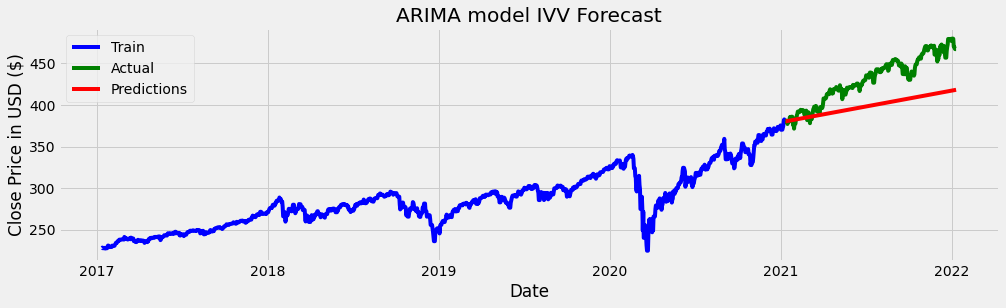

In [76]:
plt.figure(figsize=(15,4))
plt.title('ARIMA model IVV Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price in USD ($)')
plt.plot(IVV_train,c="blue",label='Train')
plt.plot(IVV_test,c='green',label='Actual')
plt.plot(yhat, c='red',label='Predictions')
plt.legend()
plt.show()

### LSTM Model

In [77]:
data = IVV.filter(['close'])
dataset = data.values
cutoff = int(len(dataset)*0.8)
cutoff

1460

In [78]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.01300991],
       [0.01465575],
       [0.01171676],
       ...,
       [0.95054665],
       [0.95054665],
       [0.95054665]])

In [79]:
# create scaled training set
train_data = scaled_data[0:cutoff,:]
X_train = []
y_train = []

for i in range(60,len(train_data)):
    X_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [80]:
# convert X_train and y_train to numpy arrays for training the model
X_train, y_train = np.array(X_train), np.array(y_train)

In [81]:
# reshape X_train for LSTM model
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(1400, 60)
(1400, 60, 1)


In [82]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [83]:
# compile the model
model.compile(optimizer='adam',loss='mean_squared_error')

In [84]:
# train the model
model.fit(X_train, y_train, batch_size=1,epochs=1)

1400/1400 [==============================] - 38s 25ms/step - loss: 9.1041e-04


In [85]:
dataset

array([[227.97],
       [228.39],
       [227.64],
       ...,
       [467.22],
       [467.22],
       [467.22]])

In [86]:
scaled_data[cutoff-60:,:].shape

(425, 1)

In [87]:
# creating test data
test_data = scaled_data[cutoff-60:,:]
X_test = []
y_test = dataset[cutoff:,:]

for i in range(60,len(test_data)):
    X_test.append(test_data[i-60:i, 0])

In [88]:
# convert X_test to numpy array
X_test = np.array(X_test)

In [89]:
# reshape X_test for LSTM model
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [90]:
# get model preds
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [91]:
# get rmse
lstm_rmse = mean_squared_error(y_test,predictions,squared=False)
lstm_rmse

4.059959112123466

In [92]:
# plot the data
train = data[:cutoff]
actual = data[cutoff:]

actual['Predictions'] = predictions

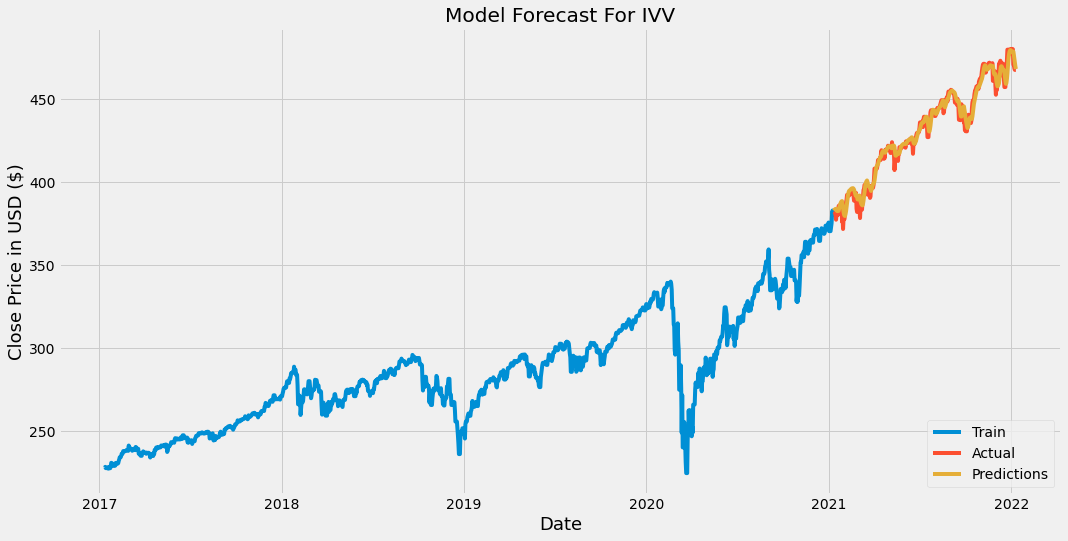

In [93]:
# visualize 
plt.figure(figsize=(16,8))
plt.title("Model Forecast For IVV")
plt.xlabel("Date",fontsize=18)
plt.ylabel("Close Price in USD ($)",fontsize=18)
plt.plot(train['close'])
plt.plot(actual['close'])
plt.plot(actual['Predictions'])
plt.legend(['Train','Actual','Predictions'],loc='lower right')
plt.show()

### FBprophet Model

In [94]:
# Helper functions

def prep_dataframe(df):
    ts = df.copy()
    ts.rename(columns={'close':'y'},inplace=True)
    ts.index.name = 'ds'
    ts = ts.reset_index()
    ts['ds'] = ts['ds'].apply(lambda x: x.replace(tzinfo=None))
    return ts

def fit_train(data,prepared=True):
    # Format dataframe to fbprophet requirements in not already done
    if prepared == False:
        data = prep_dataframe(data)

    # Train-Test Split
    cutoff = int(data.shape[0] * 0.80)
    train = data.iloc[:cutoff]
    test = data.iloc[cutoff:]

    # Fit the model
    mod = Prophet(interval_width=0.95,weekly_seasonality=True,daily_seasonality=True)
    fitted_mod = mod.fit(train)

    if prepared == False:
        return fitted_mod, data, train, test
    else:
        return fitted_mod, train, test

def get_preds(model,test_data):
    preds = model.predict(test_data[['ds']])
    return preds[['ds','yhat_lower','yhat_upper','yhat']]

def get_rmse(preds, test_data):
    return mean_squared_error(preds['yhat'],test_data['y'],squared=False)

In [95]:
mod, IVV_prepped, train, test = fit_train(IVV,False)

In [96]:
IVV_prepped.head()

,ds,y
0,2017-01-12,227.97
1,2017-01-13,228.39
2,2017-01-14,227.64
3,2017-01-15,227.64
4,2017-01-16,227.64


In [97]:
predictions = get_preds(mod,test)

In [98]:
fbprophet_rmse = get_rmse(predictions,test)

In [99]:
fbprophet_rmse

32.48823334723168

In [100]:
train = train.set_index('ds')
test = test.set_index('ds')

In [101]:
predictions = predictions[['ds','yhat']].set_index('ds')

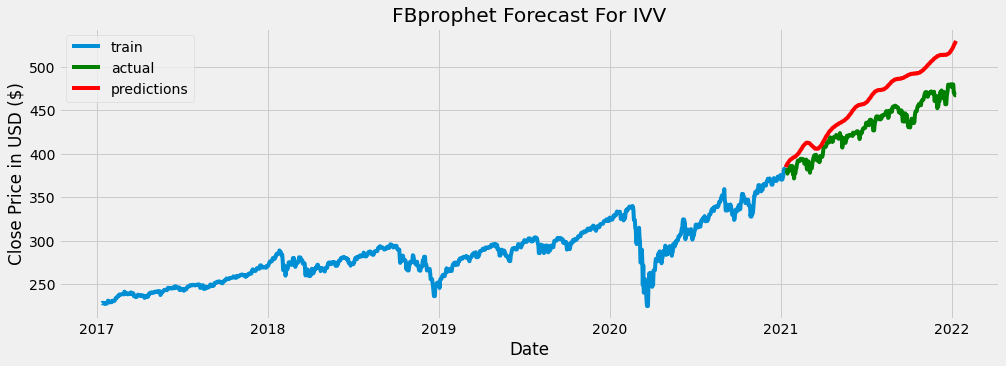

In [102]:
plt.figure(figsize=(15,5))
plt.title('FBprophet Forecast For IVV')
plt.xlabel('Date')
plt.ylabel("Close Price in USD ($)")
plt.plot(train['y'],label="train")
plt.plot(test['y'],c='green',label='actual')
plt.plot(predictions['yhat'],c='red',label='predictions')
plt.legend()
plt.show()

In [103]:
rmses = pd.Series( [baseline_rmse, arima_rmse, lstm_rmse, fbprophet_rmse], index=['Baseline','ARIMA','LSTM','FBprophet'])

In [104]:
rmses = pd.DataFrame(rmses,columns=['RMSEs'])

In [105]:
rmses

,RMSEs
Baseline,16.091709
ARIMA,36.026600
LSTM,4.059959
FBprophet,32.488233


The LSTM model performed the best, we can expect predict the closing price of the IVV index fund within an error of $4.06